# Import useful packages

In [16]:
## The following come with Anaconda 3.6
import pandas as pd    # Functions for data processing and analysis
import numpy as np     # Functions for scientific computing
import os              # Base library for dealing with file/pathnames
import zipfile         # For unzipping the Kaggle data folder
import imageio         # Python library for easy reading and writing of image data
import pathlib2 as pl  # Useful library for globbing training data from files into single image path

# Load data

- "Images" are 256x256 pixel images of cells
- "Masks" are 256x256 black/white (0/1) images of one nucleus from the image



##### Define folders

In [17]:
path = './Input_Data/'
zip_file = os.path.join(path, 'stage1_train.zip')
unzipped_dir = os.path.join(path, 'stage1_train')

zip_file_labels = os.path.join(path, 'stage1_train_labels.csv.zip')
unzipped_dir_labels = os.path.join(path, 'stage1_train_labels')

zip_file_test = os.path.join(path, 'stage1_test.zip')
unzipped_dir_test = os.path.join(path, 'stage1_test')

##### Unzip the zip file

In [18]:
# zip_ref = zipfile.ZipFile(zip_file_test, 'r')
# zip_ref.extractall(unzipped_dir_test)
# zip_ref.close()

##### Glob the training data and load a single image path

In [19]:
training_paths = pl.Path(unzipped_dir).glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[1]
im = imageio.imread(str(im_path))

print('Image Path is: \n \n {}'.format(im_path) + '\n\n')

# Print information about number of images in set
print(len([name for name in os.listdir(unzipped_dir)]))

Image Path is: 
 
 Input_Data\stage1_train\003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1\images\003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.png


670


## Dealing with color
The images in this dataset can be in RGB, RGBA and grayscale format, based on the "modality" in which they are acquired. For color images, there is a third dimension which encodes the "channel" (e.g. Red, Green, Blue). To make things simpler for this first pass, we can coerce all these images into grayscale using the rgb2gray function from scikit-image.

In [20]:
# Print the image dimensions
print('Original image shape = {}'.format(im.shape))

# Convert the image to greyscale format (if not already)
from skimage.color import rgb2gray
im_grey = rgb2gray(im)

# Print new image dimensions
print('New image shape = {}'.format(im_grey.shape))

Original image shape = (256, 256, 4)
New image shape = (256, 256)


## Plot the data

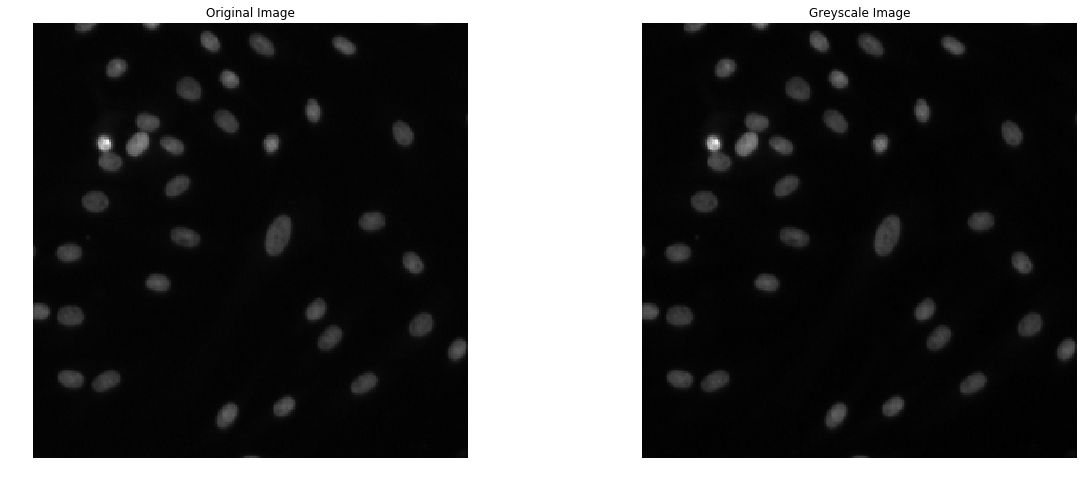

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(im_grey, cmap='gray')
plt.axis('off')
plt.title('Greyscale Image')

plt.show()

## Removing background
Perhaps the simplest approach for this problem is to assume that there are two classes in the image: objects of interest and the background. Under this assumption, we would expect the data to fall into a bimodal distribution of intensities. If we found the best separation value, we could "mask" out the background data, then simply count the objects we're left with.

The "dumbest" way we could find the threshold value would be to use a simple descriptive statistic, such as the mean or median. But there are other methods: the "Otsu" method is useful because it models the image as a bimodal distribution and finds the optimal separation value.

In [22]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(im_grey)
mask = np.where(im_grey > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

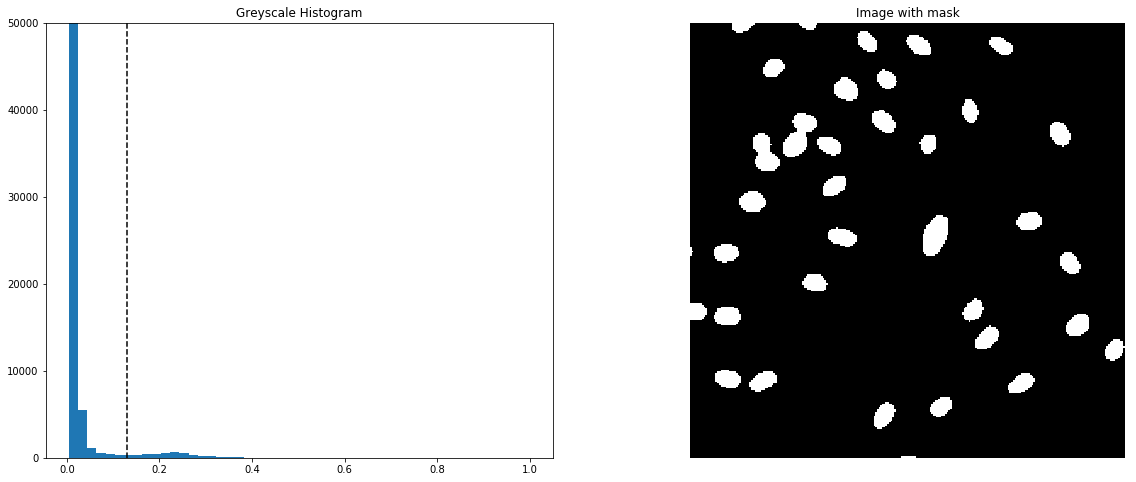

In [23]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
im_pixels = im_grey.flatten()
plt.hist(im_pixels, bins= 50)
plt.vlines(thresh_val, 0, 100000, linestyles= '--')
plt.ylim([0, 50000])
plt.title('Greyscale Histogram')

plt.subplot(1, 2, 2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(mask, cmap= 'gray')
plt.axis('off')
plt.title('Image with mask')

plt.show()


## Deriving individual masks for each object
For this contest, we need to get a separate mask for each nucleus. One way we can do this is by looking for all objects in the mask that are connected, and assign each of them a number using ndimage.label. Then, we can loop through each label_id and add it to an iterable, such as a list.

In [24]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels + 1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)
    
print('There are {} separate components / objects detected'.format(nlabels))

There are 36 separate components / objects detected


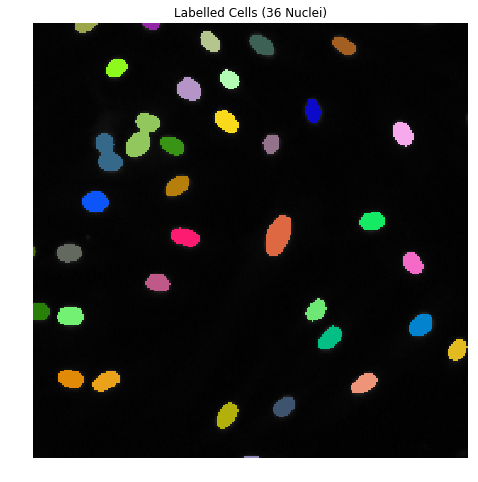

In [25]:
# Create a random colourmap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256, 3))

labels_for_display = np.where(labels > 0, labels, np.nan)

plt.figure(figsize=(20, 8))

plt.imshow(im_grey, cmap= 'gray')
plt.imshow(labels_for_display, cmap= rand_cmap)
plt.axis('off')
plt.title('Labelled Cells ({} Nuclei)'.format(nlabels))

plt.show()

A quick glance reveals two problems (in this very simple image):

- There are a few individual pixels that stand alone (e.g. top-right)
- Some cells are combined into a single mask (e.g., top-middle)

Using ndimage.find_objects, we can iterate through our masks, zooming in on the individual nuclei found to apply additional processing steps. 
find_objects returns a list of the coordinate range for each labeled object in your image.))

In [26]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_grey[label_coords]
    
    # Check if label size is too small
    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0'.format(label_ind))
        mask = np.where(labels == label_ind + 1, 0, mask)   # Set cell values to 0 (background)
        
# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected'.format(nlabels))

Label 35 is too small! Setting to 0
There are now 35 separate components / objects detected


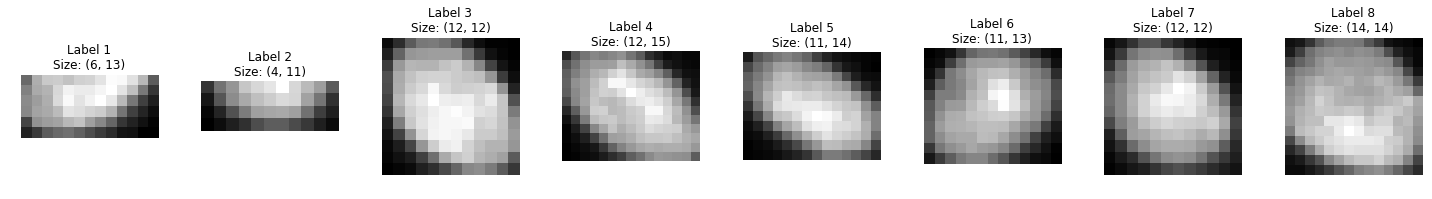

In [27]:
cells_to_show = 8

fig, axes = plt.subplots(1, cells_to_show, figsize= (20, 8))

for i, obj_indices in enumerate(ndimage.find_objects(labels)[0:cells_to_show]):
    cell = im_grey[obj_indices]
    axes[i].imshow(cell, cmap= 'gray')
    axes[i].axis('off')
    axes[i].set_title('Label {}\nSize: {}'.format(i+1, cell.shape))
    
plt.tight_layout()
plt.show()

Label #2 has the "adjacent cell" problem: the two cells are being considered part of the same object. 

One thing we can do here is to see whether we can shrink the mask to "open up" the differences between the cells. This is called mask erosion. 

We can then re-dilate it to to recover the original proportions.

In [28]:
# Get the object indices, and perform a binary opening procedure
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations= 8)

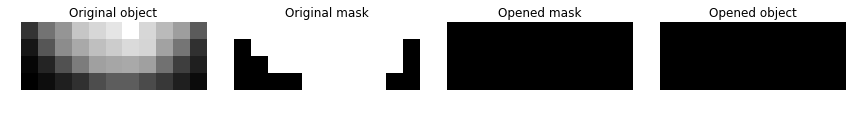

In [31]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_grey[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_grey[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Convert each labeled object to Run Line Encoding

Finally, we need to encode each label_mask into a "run line encoded" string. 

Basically, we walk through the array, and when we find a pixel that is part of the mask, we index it and count how many subsequent pixels are also part of the mask. We repeat this each time we see new pixel start point.

In [32]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 32000 1 32256 1 32512 1 32768 1 33024 1 33280 1 33536 1 33792 1 34048 1


## Combine it into a single function
Now that we've seen the basic steps to processing an image in a "dumb" way, we can combine it all into a single function. This function will take an image path, perform the processes outlined above, and spit out a dataframe with the RLE strings for each mask found.
We also create a wrapper function that will spit out a single DataFrame for all images in the dataset.

In [33]:
def analyse_image(im_path):
    '''
    [pathlib.Path object] --> [pandas.DataFrame object]
    
    Takes an image_path, preprocesses and labels it, extracts the RLE strings and dumps it into a Pandas DataFrame
    
    '''
    
    # Read in data and convert to greyscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_grey = rgb2gray(im)
    
    # Mask out background and extract connected objects
    thres_val = threshold_otsu(im_grey)
    mask = np.where(im_grey > thresh_val, 1, 0)
    if np.sum(mask == 0) < np.sum(mask == 1):
        mask = np.where(mask, 0, 1)
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)        
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels + 1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:   # Only save to DataFrame if mask is greater than 10 pixels
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index= True)      
    
    return im_df


def analyse_list_of_images(im_path_list):
    '''
    [list of pathlib.Path objects] --> [pandas.Dataframe object]
    
    Wrapper function to loop through globbed file of images and apply analyse_image function
    
    Returns a submission-ready DataFrame
    
    '''
    
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyse_image(im_path)
        all_df = all_df.append(im_df, ignore_index= True)
    
    return all_df

In [39]:
testing = pl.Path(unzipped_dir_test).glob('*/images/*.png')
submission_file = os.path.join(path, 'submission.csv')

df = analyse_list_of_images(list(testing))

# Print information about number of images in set
print(len([name for name in os.listdir(unzipped_dir_test)]))

# Count unique values in ImageId to get measure of how many images have had masks generated
print(df.ImageId.nunique())

df.groupby('ImageId').ngroup()

df.to_csv(submission_file, index=None)

65
65
